<a href="https://colab.research.google.com/github/AmritangshuM/multi-class-wildlife-detection/blob/main/Hyperparameter_sweeps_and_Evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amritangshumukherjee","key":"53f3607d46006e04b51b10966840944e"}'}

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets download -d antoreepjana/animals-detection-images-dataset
!unzip /content/animals-detection-images-dataset.zip

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt


#data_dir="/content/gdrive/MyDrive/AMLTermProject"
data_dir="/content"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")

train_classes=[os.path.basename(path) for path in all_train_subdir]
test_classes=[os.path.basename(path) for path in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))

train_image_counts={os.path.basename(path):[len(glob.glob(os.path.join(path, "*.jpg")))] for path in all_train_subdir}
test_image_counts={os.path.basename(path):[len(glob.glob(os.path.join(path, "*.jpg")))] for path in all_test_subdir}

train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df



There is 80 classes in train dataset, and 80 classes in test dataset


,train,test
Sparrow,475,131
Fish,835,617
Magpie,61,33
Crab,309,114
Shark,303,58
...,...,...
Mouse,151,83
Monkey,770,321
Cheetah,132,35
Goat,202,94


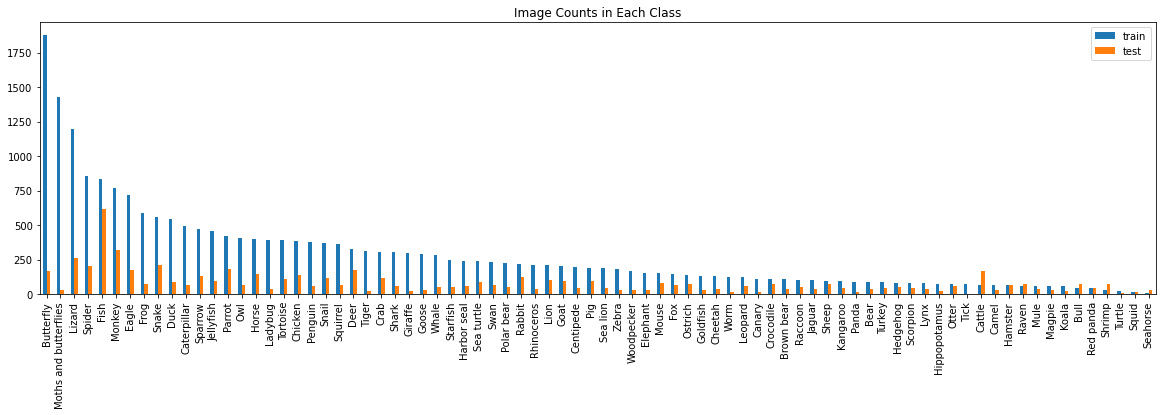

In [ ]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");

In [ ]:
def draw_image(image_file, label_file, class_names):
    class_name = os.path.basename(os.path.dirname(image_file))    
    image = cv2.imread(image_file)
        
    with open(label_file) as fobj:
        while True:            
            item = fobj.readline()
            if item is None or len(item)<=0:
                break
            item = item[len(class_name):]
            item = item.split()
            xmin = float(item[0])
            ymin = float(item[1])
            xmax = float(item[2])
            ymax = float(item[3])
        
            image = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 3)
            image = cv2.putText(image, class_name, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 3)
        
    return image


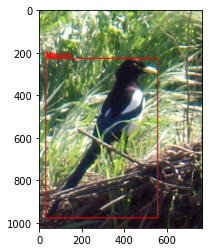

In [ ]:
subdir = all_test_subdir[2]
image_files = glob.glob(os.path.join(subdir, "*.jpg"))

image_file = image_files[0]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))

image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
plt.imshow(image);

In [ ]:
#os.chdir('/content/gdrive/MyDrive/AMLTermProject')

yolo_train_dir = "/content/yolo/train"
yolo_test_dir = "/content/yolo/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

/content/yolo/train/images
/content/yolo/train/labels
/content/yolo/test/images
/content/yolo/test/labels


In [ ]:
def process_dataset(subdirs, dst_dir, class_names, size=(640,640), link=False):
    for subdir_id in tqdm(range(len(subdirs))):
        subdir = subdirs[subdir_id]
        prefix=os.path.basename(subdir)
        for image_file in glob.glob(os.path.join(subdir, "*.jpg")):
            #print('check')
            image_file_basename=os.path.basename(image_file)
            label_file = os.path.join(subdir, "Label", image_file_basename).replace(".jpg", ".txt")
            dst_image_file = os.path.join(dst_dir, "images/%s_%s"%(prefix,image_file_basename))
            dst_label_file = os.path.join(dst_dir, "labels/%s_%s"%(prefix,image_file_basename.replace(".jpg", ".txt")))
            if os.path.exists(dst_label_file):
                continue
            if os.path.exists(label_file)==False:
                continue

            #print('check1')       
            image = cv2.imread(image_file)                
            height, width = image.shape[0:2]
            with open(label_file) as fobj:
                with open(dst_label_file, "w") as wobj:
                    while True:
                        item = fobj.readline()
                        if item is None or len(item)==0:
                            break
                        #print('check2')
                        class_name = prefix
                        item=item[len(class_name):]
                        item = item.split()
                        xmin = float(item[0])
                        ymin = float(item[1])
                        xmax = float(item[2])
                        ymax = float(item[3])

                        cx   = (xmin + xmax)/2.0/width
                        cy   = (ymin + ymax)/2.0/height
                        bw   = (xmax - xmin)/width
                        bh   = (ymax - ymin)/height
                        class_id = class_names.index(class_name)
                        output_line = "%d %f %f %f %f\n"%(class_id, cx, cy, bw, bh)
                        wobj.write(output_line)

            if link==True:
                os.symlink(image_file, dst_image_file)
            else:
                image = cv2.resize(image, size)
                cv2.imwrite(dst_image_file, image)
    

In [ ]:
for subdir_id in tqdm(range(len(all_train_subdir))):
    subdir = all_train_subdir[subdir_id]

100%|██████████| 80/80 [00:00<00:00, 550072.66it/s]


In [ ]:
# process_dataset(all_train_subdir, yolo_train_dir, train_classes, size=(640,640), link=False)        
xueqin_train_subdir=all_train_subdir
xueqin_classes=[os.path.basename(pp) for pp in xueqin_train_subdir]

process_dataset(xueqin_train_subdir, yolo_train_dir, xueqin_classes, size=(640,640), link=False) 

100%|██████████| 80/80 [08:31<00:00,  6.40s/it]


In [ ]:
xueqin_test_subdir=all_test_subdir
process_dataset(xueqin_test_subdir, yolo_test_dir, xueqin_classes, size=(640,640), link=False)  

100%|██████████| 80/80 [02:31<00:00,  1.90s/it]


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt
#%cd -

Cloning into 'yolov5'...
remote: Enumerating objects: 14184, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 14184 (delta 76), reused 96 (delta 64), pack-reused 14060
Receiving objects: 100% (14184/14184), 13.61 MiB | 31.82 MiB/s, done.
Resolving deltas: 100% (9732/9732), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.5 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 1.6 MB 41.2 MB/s 


In [ ]:
yaml_file="/content/yolov5/data/animal_detect1.yaml"
train_images_dir = os.path.join("..", yolo_train_dir, "images")
val_images_dir = os.path.join("..", yolo_test_dir, "images")

names_str=""
for item in xueqin_classes:
    names_str=names_str + ", \'%s\'"%item
names_str= "names: ["+names_str[1:]+"]"

with open(yaml_file, "w") as wobj:
    wobj.write("train: %s\n"%train_images_dir)
    wobj.write("val: %s\n"%val_images_dir)
    wobj.write("nc: %d\n"%len(xueqin_classes))
    wobj.write(names_str+"\n")

In [ ]:
!cat /content/yolov5/data/animal_detect1.yaml

train: /content/yolo/train/images
val: /content/yolo/test/images
nc: 80
names: [ 'Sparrow', 'Fish', 'Magpie', 'Crab', 'Shark', 'Penguin', 'Rabbit', 'Jellyfish', 'Red panda', 'Swan', 'Giraffe', 'Mule', 'Tick', 'Lizard', 'Goldfish', 'Owl', 'Scorpion', 'Frog', 'Turkey', 'Bull', 'Canary', 'Hippopotamus', 'Squirrel', 'Spider', 'Bear', 'Zebra', 'Camel', 'Turtle', 'Cattle', 'Sea lion', 'Worm', 'Harbor seal', 'Deer', 'Centipede', 'Hedgehog', 'Eagle', 'Lion', 'Parrot', 'Elephant', 'Sheep', 'Horse', 'Kangaroo', 'Panda', 'Ladybug', 'Raven', 'Duck', 'Starfish', 'Brown bear', 'Otter', 'Sea turtle', 'Shrimp', 'Seahorse', 'Snake', 'Rhinoceros', 'Polar bear', 'Koala', 'Hamster', 'Moths and butterflies', 'Crocodile', 'Woodpecker', 'Goose', 'Snail', 'Chicken', 'Fox', 'Butterfly', 'Ostrich', 'Pig', 'Lynx', 'Tiger', 'Raccoon', 'Tortoise', 'Squid', 'Jaguar', 'Leopard', 'Whale', 'Mouse', 'Monkey', 'Cheetah', 'Goat', 'Caterpillar']


In [ ]:
!pip install "wandb==0.12.10"
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.5 MB/s 
     |████████████████████████████████| 168 kB 58.3 MB/s 
     |████████████████████████████████| 168 kB 54.6 MB/s 
     |████████████████████████████████| 166 kB 57.2 MB/s 
     |████████████████████████████████| 166 kB 64.3 MB/s 
     |████████████████████████████████| 162 kB 56.7 MB/s 
     |████████████████████████████████| 162 kB 52.6 MB/s 
     |████████████████████████████████| 158 kB 12.7 MB/s 
     |████████████████████████████████| 157 kB 51.2 MB/s 
     |████████████████████████████████| 157 kB 56.3 MB/s 
     |████████████████████████████████| 157 kB 12.3 MB/s 
     |████████████████████████████████| 157 kB 51.7 MB/s 
     |████████████████████████████████| 157 kB 59.2 MB/s 
     |████████████████████████████████| 157 kB 56.7 MB/s 
     |████████████████████████████████| 157 kB 55.8 MB/s 
     |██████████████████████████

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!wandb sweep /content/yolov5/utils/loggers/wandb/sweep.yaml

wandb: Creating sweep from: /content/yolov5/utils/loggers/wandb/sweep.yaml
wandb: Created sweep with ID: nzs6z5y5
wandb: View sweep at: https://wandb.ai/amritangshu/yolov5-utils_loggers_wandb/sweeps/nzs6z5y5
wandb: Run sweep agent with: wandb agent amritangshu/yolov5-utils_loggers_wandb/nzs6z5y5


In [ ]:
!wandb agent amritangshu/yolov5-utils_loggers_wandb/nzs6z5y5

wandb: Starting wandb agent 🕵️
2022-11-28 07:53:05,465 - wandb.wandb_agent - INFO - Running runs: []
2022-11-28 07:53:05,647 - wandb.wandb_agent - INFO - Agent received command: run
2022-11-28 07:53:05,647 - wandb.wandb_agent - INFO - Agent starting run with config:
	anchor_t: 4.844437784948131
	batch_size: 64
	box: 0.1488511323921571
	cls: 2.7794003523106854
	cls_pw: 1.8125557464624231
	copy_paste: 0.579217413243044
	data: /content/yolov5/data/animal_detect1.yaml
	degrees: 21.59909806387507
	epochs: 10
	fl_gamma: 1.5773345666789087
	fliplr: 0.5089236548924775
	flipud: 0.9923252533524304
	hsv_h: 0.04237502370895161
	hsv_s: 0.3578018825521393
	hsv_v: 0.5827732143258633
	iou_t: 0.49526177065900134
	lr0: 0.06747186431545109
	lrf: 0.5758166776688675
	mixup: 0.6208488291172919
	momentum: 0.7941510744469087
	mosaic: 0.1395664016003495
	obj: 2.7000019503444657
	obj_pw: 1.6394622102166947
	perspective: 0.0008825731522265768
	scale: 0.7872455580514258
	shear: 4.511717415584182
	translate: 0.267

In [ ]:
!python val.py --weights /content/yolo5_best.pt --data /content/yolov5/data/animal_detect1.yaml --img 640 --half

val: data=/content/yolov5/data/animal_detect1.yaml, weights=['/content/yolo5_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-8-g350e8eb Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7459581 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 52.8MB/s]
val: Scanning /content/yolo/test/labels... 6505 images, 0 backgrounds, 0 corrupt: 100% 6505/6505 [00:06<00:00, 988.18it/s] 
val: New cache created: /content/yolo/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 204/204 [01:25<00:00,  2.40it/s]
                   all       6505       7576   0.000908     0.0862   0.000838   0.000356
Speed: 0.2ms pre-pr

In [ ]:
!python val.py --weights /content/yolo5_best.pt /content/yolo5_1.pt --data /content/yolov5/data/animal_detect1.yaml --img 640 --half

val: data=/content/yolov5/data/animal_detect1.yaml, weights=['/content/yolo5_best.pt', '/content/yolo5_1.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-8-g350e8eb Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7459581 parameters, 0 gradients
Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Ensemble created with ['/content/yolo5_best.pt', '/content/yolo5_1.pt']

val: Scanning /content/yolo/test/labels.cache... 6505 images, 0 backgrounds, 0 corrupt: 100% 6505/6505 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 204/204 [01:31<00:00,  2.22it/s]
                   al

In [ ]:
!python val.py --weights yolov5x.pt yolov5l6.pt --data /content/yolov5/data/animal_detect1.yaml --img 640 --half

val: data=/content/yolov5/data/animal_detect1.yaml, weights=['yolov5x.pt', 'yolov5l6.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-8-g350e8eb Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

100% 166M/166M [00:06<00:00, 27.0MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
100% 147M/147M [00:07<00:00, 20.1MB/s]

Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients
Ensemble created with ['yolov5x.pt', 'yolov5l6.pt']

val: Scanning /content/yolo/test/labels.cache... 6505 images, 0 backgrounds, 0 corrupt: 100% 6505/6505 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 204/204 [04:49<00:00,  1.42s/

In [ ]:
!python /content/gdrive/MyDrive/AMLTermProject/yolov5/detect.py --weights /content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt --source /content/gdrive/MyDrive/AMLTermProject/yolo/test/images/Bear_1fa809bf6cf5ea36.jpg --name animals --project runs/detect

detect: weights=['/content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt'], source=/content/gdrive/MyDrive/AMLTermProject/yolo/test/images/Bear_1fa809bf6cf5ea36.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=animals, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /content/gdrive/MyDrive/AMLTermProject/yolo/test/images/Bear_1fa809bf6cf5ea36.jpg: 640x640 (no detections), 13.5ms
Speed: 0.6ms pre-process, 13.5ms inference, 0.7ms NMS per image at shape (1, 3, 640, 640)
Results s

In [ ]:
!python /content/gdrive/MyDrive/AMLTermProject/yolov5/export.py --weights /content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt --include onnx --simplify

export: data=yolov5/data/coco128.yaml, weights=['/content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs

PyTorch: starting from /content/gdrive/MyDrive/AMLTermProject/yolov5/runs/train/Model2/weights/best.pt with output shape (1, 25200, 85) (14.2 MB)
requirements: YOLOv5 requirement "onnx" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per ['onnx']
requirements: ⚠️ Restart runtime or rerun command 